# Predicting Red Wine Quality, Part 2
Data from http://archive.ics.uci.edu/ml/datasets/Wine+Quality

## Citations
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties.
In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.

Available at:
- [@Elsevier](http://dx.doi.org/10.1016/j.dss.2009.05.016)
- [Pre-press (pdf)](http://www3.dsi.uminho.pt/pcortez/winequality09.pdf)
- [bib](http://www3.dsi.uminho.pt/pcortez/dss09.bib)

Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.
## Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
red_wine = pd.read_csv('data/winequality-red.csv')
red_wine['high_quality'] = pd.cut(red_wine.quality, bins=[0, 6, 10], labels=[0, 1])

Since we completed our EDA in the [red_wine.ipynb notebook for last chapter](https://github.com/stefmolin/Hands-On-Data-Analysis-with-Pandas/blob/master/ch_09/red_wine.ipynb), we will just look at the first 5 rows to refresh our memory of the data rather than repeating the EDA here.

In [3]:
red_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,high_quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


## Train Test Split

In [4]:
from sklearn.model_selection import train_test_split

red_y = red_wine.pop('high_quality')
red_X = red_wine.drop(columns='quality')

r_X_train, r_X_test, r_y_train, r_y_test = train_test_split(
    red_X, red_y, test_size=0.1, random_state=0, stratify=red_y
)

## Searching for the Best Hyperparameters with Plots

In [5]:
from sklearn.model_selection import train_test_split

r_X_train_new, r_X_validate, r_y_train_new, r_y_validate = train_test_split(
    r_X_train, r_y_train, test_size=0.3, random_state=0, stratify=r_y_train
)

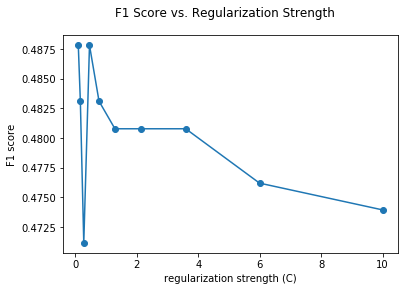

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

regularization_strengths = np.logspace(-1, 1, num=10)
scores = []

for regularization_strength in regularization_strengths:
    pipeline = Pipeline([
        ('scale', MinMaxScaler()),
        ('lr', LogisticRegression(
            solver='lbfgs', class_weight='balanced',
            random_state=0, C=regularization_strength
        ))
    ]).fit(r_X_train_new, r_y_train_new)
    scores.append(f1_score(pipeline.predict(r_X_validate), r_y_validate))

plt.plot(regularization_strengths, scores,'o-')
plt.xlabel('regularization strength (C)')
plt.ylabel('F1 score')
plt.suptitle('F1 Score vs. Regularization Strength')

## Searching for Best Hyperparameters with GridSearchCV

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

pipeline = Pipeline([
    ('scale', MinMaxScaler()),
    ('lr', LogisticRegression(
        solver='lbfgs', class_weight='balanced', random_state=0
    ))
])

search_space = {
    'lr__C': np.logspace(-1, 1, num=10), # regularization strength
    'lr__fit_intercept' : [True, False]
}
lr_grid = GridSearchCV(pipeline, search_space, scoring='f1', cv=5).fit(r_X_train, r_y_train)

In [8]:
lr_grid.best_params_

{'lr__C': 10.0, 'lr__fit_intercept': True}

In [9]:
lr_grid.best_score_

0.5091665163898992

### GridSearchCV with CV Object

In [10]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

lr_grid = GridSearchCV(
    pipeline, search_space, scoring='f1', 
    cv=RepeatedStratifiedKFold(random_state=0)
).fit(r_X_train, r_y_train)

In [11]:
print("Best parameters (CV score=%.2f): %s" % (
    lr_grid.best_score_, lr_grid.best_params_
))

Best parameters (CV score=0.51): {'lr__C': 3.593813663804626, 'lr__fit_intercept': True}


## Feature Unions

In [12]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

combined_features = FeatureUnion(
    [("pca", PCA(2, random_state=0)), ("k_best", SelectKBest(k=5))]
)

pipeline = Pipeline([
    ('normalize', MinMaxScaler()),
    ('feature_union', combined_features),
    ('lr', LogisticRegression(
        solver='lbfgs', class_weight='balanced', random_state=0
    ))
]).fit(r_X_train, r_y_train)

In [13]:
# see the feature union (first 2 are PCA, last 5 are k best)
pipeline.named_steps['feature_union'].transform(r_X_train)[0]

array([ 3.65612971,  2.7038386 ,  0.35      ,  0.55      ,  0.9971    ,
        0.79      , 10.6       ])

In [14]:
from sklearn.metrics import classification_report

preds = pipeline.predict(r_X_test)
print(classification_report(r_y_test, preds))

              precision    recall  f1-score   support

           0       0.94      0.80      0.86       138
           1       0.35      0.68      0.46        22

   micro avg       0.78      0.78      0.78       160
   macro avg       0.64      0.74      0.66       160
weighted avg       0.86      0.78      0.81       160



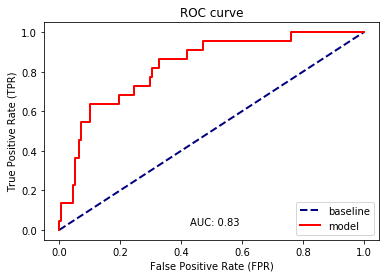

In [15]:
from utils import plot_roc
plot_roc(r_y_test, pipeline.predict_proba(r_X_test)[:,1])

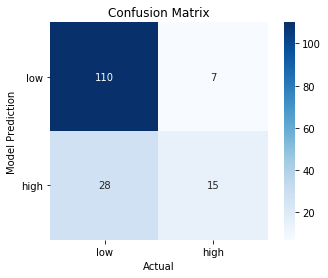

In [16]:
from utils import confusion_matrix_visual
confusion_matrix_visual(r_y_test, preds, ['low', 'high'])

## Ensemble Method: Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(n_estimators=100, random_state=0)

search_space = {
    'max_depth' : [4, 8],
    'min_samples_leaf' : [4, 6]
}

rf_grid = GridSearchCV(
    rf, search_space, cv=5, scoring='precision'
).fit(r_X_train, r_y_train)

rf_preds = rf_grid.predict(r_X_test)
rf_grid.score(r_X_test, r_y_test)

c:\users\stefanie\hands_on_pandas\venv\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.6

## Ensemble Method: Gradient Boosted Trees

In [18]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

gb = GradientBoostingClassifier(n_estimators=100, random_state=0)
search_space = {
    'max_depth' : [4, 8],
    'min_samples_leaf' : [4, 6],
    'learning_rate' : [0.1, 0.5, 1]
}

gb_grid = GridSearchCV(
    gb, search_space, cv=5, scoring='f1'
).fit(r_X_train, r_y_train)

gb_preds = gb_grid.predict(r_X_test)
gb_grid.score(r_X_test, r_y_test)

0.5128205128205129

## Voting

Check agreement between the gradient boosting classifier and the random forest range is [-1, 1]

In [19]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(
    rf_grid.predict(r_X_test), gb_grid.predict(r_X_test)
)

0.7185929648241206

In [20]:
from sklearn.ensemble import VotingClassifier

majority_rules = VotingClassifier(
    [('lr', lr_grid.best_estimator_), ('rf', rf_grid.best_estimator_), ('gb', gb_grid.best_estimator_)],
    voting='hard'
).fit(r_X_train, r_y_train)

max_probabilities = VotingClassifier(
    [('lr', lr_grid.best_estimator_), ('rf', rf_grid.best_estimator_), ('gb', gb_grid.best_estimator_)],
    voting='soft'
).fit(r_X_train, r_y_train)

Agreement between majority rules and max probabilities.

In [21]:
cohen_kappa_score(
    majority_rules.predict(r_X_test), max_probabilities.predict(r_X_test)
)

0.8807305255311219

### Majority Rules

In [22]:
majority_rules_preds = majority_rules.predict(r_X_test)

In [23]:
from sklearn.metrics import classification_report
print(classification_report(r_y_test, majority_rules_preds))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       138
           1       0.59      0.45      0.51        22

   micro avg       0.88      0.88      0.88       160
   macro avg       0.75      0.70      0.72       160
weighted avg       0.87      0.88      0.87       160



### Max Probabilities

In [24]:
max_prob_preds = max_probabilities.predict(r_X_test)

In [25]:
from sklearn.metrics import classification_report
print(classification_report(r_y_test, max_prob_preds))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       138
           1       0.52      0.50      0.51        22

   micro avg       0.87      0.87      0.87       160
   macro avg       0.72      0.71      0.72       160
weighted avg       0.87      0.87      0.87       160



## Class Imbalances
KNN for baseline

In [26]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(
    n_neighbors=5
).fit(r_X_train, r_y_train)

knn_preds = knn.predict(r_X_test)

In [27]:
from sklearn.metrics import classification_report
print(classification_report(r_y_test, knn_preds))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       138
           1       0.50      0.41      0.45        22

   micro avg       0.86      0.86      0.86       160
   macro avg       0.70      0.67      0.69       160
weighted avg       0.85      0.86      0.86       160



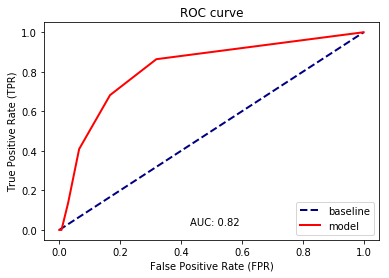

In [28]:
from utils import plot_roc
plot_roc(r_y_test, knn.predict_proba(r_X_test)[:,1])

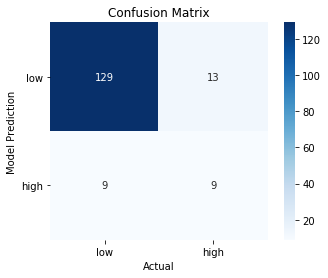

In [29]:
from utils import confusion_matrix_visual
confusion_matrix_visual(r_y_test, knn_preds, ['low', 'high'])

### Random under-sampling

In [30]:
from imblearn.under_sampling import RandomUnderSampler

X_train_undersampled, y_train_undersampled = RandomUnderSampler(
    random_state=0
).fit_resample(r_X_train, r_y_train)

In [31]:
r_y_train.value_counts() # before

0    1244
1     195
Name: high_quality, dtype: int64

In [32]:
pd.Series(y_train_undersampled).value_counts().sort_index() # after

0    195
1    195
dtype: int64

In [33]:
from sklearn.neighbors import KNeighborsClassifier

knn_undersampled = KNeighborsClassifier(
    n_neighbors=5
).fit(X_train_undersampled, y_train_undersampled)

knn_undersampled_preds = knn_undersampled.predict(r_X_test)

In [34]:
from sklearn.metrics import classification_report
print(classification_report(r_y_test, knn_undersampled_preds))

              precision    recall  f1-score   support

           0       0.93      0.65      0.77       138
           1       0.24      0.68      0.35        22

   micro avg       0.66      0.66      0.66       160
   macro avg       0.58      0.67      0.56       160
weighted avg       0.83      0.66      0.71       160



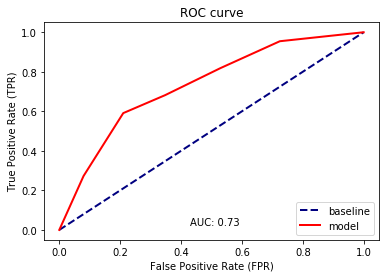

In [35]:
from utils import plot_roc
plot_roc(r_y_test, knn_undersampled.predict_proba(r_X_test)[:,1])

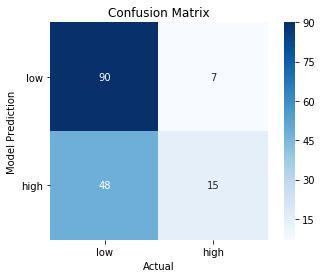

In [36]:
from utils import confusion_matrix_visual
confusion_matrix_visual(r_y_test, knn_undersampled_preds, ['low', 'high'])

### Over-sampling with SMOTE

In [37]:
from imblearn.over_sampling import SMOTE

X_train_oversampled, y_train_oversampled = SMOTE(
    random_state=0
).fit_resample(r_X_train, r_y_train)

In [38]:
r_y_train.value_counts() # before

0    1244
1     195
Name: high_quality, dtype: int64

In [39]:
pd.Series(y_train_oversampled).value_counts().sort_index() # after

0    1244
1    1244
dtype: int64

In [40]:
from sklearn.neighbors import KNeighborsClassifier

knn_oversampled = KNeighborsClassifier(
    n_neighbors=5
).fit(X_train_oversampled, y_train_oversampled)

knn_oversampled_preds = knn_oversampled.predict(r_X_test)

In [41]:
from sklearn.metrics import classification_report
print(classification_report(r_y_test, knn_oversampled_preds))

              precision    recall  f1-score   support

           0       0.96      0.78      0.86       138
           1       0.37      0.82      0.51        22

   micro avg       0.78      0.78      0.78       160
   macro avg       0.67      0.80      0.68       160
weighted avg       0.88      0.78      0.81       160



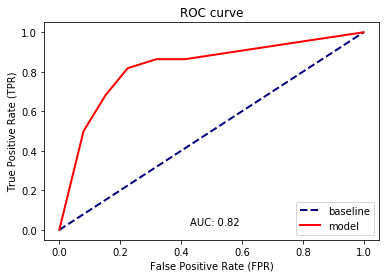

In [42]:
from utils import plot_roc
plot_roc(r_y_test, knn_oversampled.predict_proba(r_X_test)[:,1])

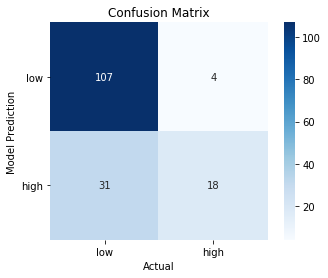

In [43]:
from utils import confusion_matrix_visual
confusion_matrix_visual(r_y_test, knn_oversampled_preds, ['low', 'high'])